#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Chess Piece Evaluation and Result Prediction </p>

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Import libraries and Load Data</p>

In [1]:
# basic libraries
import os
import numpy as np
import pandas as pd
import sklearn 

# cleaning
import re 

# modelling process
from sklearn.model_selection import train_test_split

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

# neural network models
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# evaluation metrics
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# chess module
import chess
from chess import pgn
from chess import Board

# math 
import math
from statistics import mean
from statistics import stdev

# plotting
from matplotlib import pyplot as plt

In [3]:
# Load raw data
directory = os.getcwd()
with open(directory + "/raw_fics.txt", 'r') as f:
    raw_data_fics = f.read()
with open(directory + "/raw_pgnmentor.txt", 'r', encoding = "latin-1") as f:
    raw_data_pgnmentor = f.read()

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Data Cleaning</p>

I have dataframes containing chess games from two different sources. One is from 'pgnmentor.com' and carries data from official tournaments between chess players with Elo scores over 2000, considered 'experts.' The other is from the Free Internet Chess Server (FICS) and contains games from players with Elo scores from more inexperienced players; I will restrict to chess players with Elo scores between 1000 and 1600. 

The data I've collected from these two sources are in somewhat dirty text files, with lots of missing information and non-uniform formatting between games. I clean both in the hidden code blocks that follow, to the point that we can represent the data in dataframes instead of text files. 

In [10]:
### CLEANING THE RAW FICS DATA ### 

# Split the text file into individual games
temp = raw_data_fics.split('[Event')[1:] 

# Remove all games where 1+ players are computers
computer_indices = reversed([i for i in range(len(temp)) if "Comp" in temp[i]])
for index in computer_indices:
    temp.pop(index)
    
# Organize into dataframe
temp = [x.replace('\n', " ").split(']') for x in temp] # Split the entries for each game
temp = [[(x.split('"')[1] if len(x.split('"')) > 1 else x)  for x in game] for game in temp] # Extract data from between quotations
columns = ["GameType", "Site", "GameNo", "White", "Black", "WhiteElo", "BlackElo", "WhiteRD", "BlackRD", "TimeControl", "Date", 
           "Time", "WhiteClock", "BlackClock", "ECO", "PlyCount", "Result", "PGN"]
unfeatured_fics = pd.DataFrame(temp, columns = columns)

# Drop miscellaneous columns we won't need 
columns_to_drop = ["GameType", "Site", "GameNo", "White", "Black", "WhiteRD", "BlackRD"]
unfeatured_fics.drop(columns_to_drop, axis = 1, inplace = True)

# Remove games that were won or lost by internet disconnection
unfeatured_fics = unfeatured_fics[unfeatured_fics["PGN"].apply(lambda x: "disconnection" not in x)]

# Remove information on how the game was won or lost (distinguising checkmate and resignation)
unfeatured_fics["PGN"] = unfeatured_fics["PGN"].apply(lambda s: re.sub("\{.*\}","", s) )

# Let the "Result" column contain only values 0 (white wins), 1 (black wins), or 2 (tie)
unfeatured_fics["Result"].replace({"1-0": 0, "0-1": 1, "1/2-1/2": 2}, inplace = True)

# Convert these columns from object type to int type 
unfeatured_fics["WhiteElo"], unfeatured_fics["BlackElo"]  =  unfeatured_fics["WhiteElo"].astype(int), unfeatured_fics["BlackElo"].astype(int)

# Select only the games where players have an Elo rating between 1000 and 1600
unfeatured_fics = unfeatured_fics[(unfeatured_fics["WhiteElo"] <= 1600) & (unfeatured_fics["WhiteElo"] >= 1000)\
                                 & (unfeatured_fics["BlackElo"] <= 1600) & (unfeatured_fics["BlackElo"] >= 1000)]

In [5]:
### CLEANING THE RAW PGNMENTOR DATA ### 

# Separate the text file into individual games 
temp = raw_data_pgnmentor.split('[Event ')[1:]

# Extract features for each game 
temp = [game.replace('\n', " ").split(']') for game in temp] # For each game, split the different features
temp = [[(x.split('"')[1] if len(x.split('"')) > 1 else x)  for x in game] for game in temp] # Extract information from inside quotations

# Most games have exactly 11 features, but a small number (about 400, or 1/1000th of all games) have a different format. Remove them.
remove_indices = reversed([i for i in range(len(temp)) if len(temp[i]) != 11])
for index in remove_indices:
    temp.pop(index)

# Create dataframe from data
columns = ["Event", "Site", "Date", "Round", "White", "Black", "Result", "WhiteElo", "BlackElo", "ECO", "PGN"]
unfeatured_pgnmentor = pd.DataFrame(temp, columns = columns)

# Remove duplicate games. 
# The games were originally recorded by player, so that almost all games are recorded twice - from the perspective of white and of black. 
# This can be fixed by requiring White player's name < Black player's name
unfeatured_pgnmentor = unfeatured_pgnmentor[unfeatured_pgnmentor["White"] < unfeatured_pgnmentor["Black"]]

# In the column "Result", record the result of each game as 0 for white wins, 1 for black wins, 2 for tie
unfeatured_pgnmentor["Result"].replace({"1-0": 0, "0-1": 1, "1/2-1/2" : 2}, inplace = True) 

# Remove the two entries with a missing value (written as '*') as the Result 
unfeatured_pgnmentor.drop(unfeatured_pgnmentor[unfeatured_pgnmentor["Result"] == "*"].index, inplace = True)

# Replace empty strings with np.nan
unfeatured_pgnmentor.replace({"": np.nan}, inplace = True)

# Fix dtypes
unfeatured_pgnmentor["Result"] = unfeatured_pgnmentor["Result"].astype(int)
unfeatured_pgnmentor["WhiteElo"] = unfeatured_pgnmentor["WhiteElo"].astype(float) 
unfeatured_pgnmentor["BlackElo"] = unfeatured_pgnmentor["BlackElo"].astype(float) 

# Remove leading and trailing whitespace for PGN feature
unfeatured_pgnmentor["PGN"] = unfeatured_pgnmentor["PGN"].apply(lambda x: x.strip())

See below for what our dataframes look like now. Some of the key columns here are:
* WhiteElo: Elo score of White
* BlackElo: Elo score of Black
* ECO: Classification for chess openings
* Result: 0 if White Wins, 1 if Black Wins, 2 if Tie 
* PGN: PGN stands for Portable Game Notation. It is a compact way to store all information about every move the players made throughout the game.

In [8]:
unfeatured_fics.head()

,WhiteElo,BlackElo,TimeControl,Date,Time,WhiteClock,BlackClock,ECO,PlyCount,Result,PGN
2,1356,1296,1200+10,2021.12.28,11:58:00,0:20:00.000,0:20:00.000,B07,163,2,1. e4 d6 2. d4 Nf6 3. Nc3 Ng4 4. Qe2 h5 5. h...
3,1396,1389,900+1,2021.12.27,11:18:00,0:15:00.000,0:15:00.000,C25,59,0,1. e4 e5 2. Nc3 Bb4 3. Bc4 Bxc3 4. bxc3 Nf6 ...
4,1289,1306,1800+30,2021.12.27,08:14:00,0:30:00.000,0:30:00.000,D00,56,1,1. d4 d5 2. Bf4 e6 3. Nf3 Bd6 4. Bg5 Nf6 5. ...
5,1388,1388,900+0,2021.12.26,20:55:00,0:15:00.000,0:15:00.000,C62,89,0,1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. Bxc6+ bxc6 ...
6,1396,1380,900+0,2021.12.26,20:28:00,0:15:00.000,0:15:00.000,D02,68,1,1. d4 d5 2. Nf3 Nc6 3. e3 a6 4. a4 Bg4 5. Be...


In [9]:
unfeatured_pgnmentor.head()

,Event,Site,Date,Round,White,Black,Result,WhiteElo,BlackElo,ECO,PGN
0,Lloyds Bank op,London,1984.??.??,1,"Adams, Michael","Sedgwick, David",0,NaN,NaN,C05,1.e4 e6 2.d4 d5 3.Nd2 Nf6 4.e5 Nfd7 5.f4 c5 6....
1,Lloyds Bank op,London,1984.??.??,3,"Adams, Michael","Dickenson, Neil F",0,NaN,2230.0,C07,1.e4 e6 2.d4 d5 3.Nd2 c5 4.exd5 Qxd5 5.Ngf3 cx...
4,Lloyds Bank op,London,1984.??.??,6,"Adams, Michael","Levitt, Jonathan",2,NaN,2370.0,B99,1.e4 c5 2.Nf3 d6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 a6...
5,Lloyds Bank op,London,1984.??.??,9,"Adams, Michael","Saeed, Saeed Ahmed",0,NaN,2430.0,B56,1.e4 c5 2.Nf3 Nc6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 d...
6,BCF-ch,Edinburgh,1985.??.??,1,"Adams, Michael","Singh, Sukh Dave",2,2360.0,2080.0,B70,1.e4 c5 2.Nf3 d6 3.d4 cxd4 4.Nxd4 Nf6 5.Nc3 g6...


We are not interested in training our classification model to predict a 'Tie' result, as opposed to White or Black winning. Ties will only make our model harder to train, without teaching us about which player has an advantage at any point in the game. I drop all rows that have ties in the code block below. 

In [11]:
# Dropping ties. 
unfeatured_pgnmentor = unfeatured_pgnmentor[unfeatured_pgnmentor["Result"] != 2]
unfeatured_fics = unfeatured_fics[unfeatured_fics["Result"] != 2]

In [14]:
print('There are {} expert games and {} amateur games in our remaining data after cleaning.'.format(unfeatured_pgnmentor.shape[0], unfeatured_fics.shape[0]))

There are 119218 expert games and 17292 amateur games in our remaining data after cleaning.


#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Feature Engineering (Part 1)</p>

In our current dataframes, all the information we have about the chess games lies in the 'PGN' column. The PGN feature contains long strings giving each move by White and Black, in order. 

See the example below. Every pair of moves from white and black is numbered, '1.', '2.', and so on. Each move is contains a few parts:
* The piece: The pieces are represented as K (king), Q (queen), R (rook), B (bishop), N (knight). White's pieces are capital letters, and Black's pieces are lower-case letters. If no piece is specified, a pawn is moving. 
* The position a piece moves to: These positions contain a letter and number, like 'e4'. The letter refers to the column or 'file' in the chess board, and the number refers to the row or 'rank'. See the chess board below to see how each letter and number combination maps to a position on the board. 
* The letter 'x': if 'x' is present in the move, that means some piece on the opposing side was captured. 
* Castling: Castling is written as 'O-O' (King's Castle) or 'O-O-O' (Queen's Castle). 
* Check and Checkmate: If a player checks another player, a '+' is appended to the end of the move. If a checkmate occurs, a '#' is appended to the end of the move. 

At the end of the string, the result of the game is written as 1-0 (White wins) or 0-1 (Black wins). Note that ties have been removed from our data set. 

In [17]:
print('An example of a game in PGN format is as follows')
print(unfeatured_fics.iloc[0, -1])

An example of a game in PGN format is as follows
  1. e4 e5 2. Nc3 Bb4 3. Bc4 Bxc3 4. bxc3 Nf6 5. d3 a6 6. f4 exf4 7. a3 O-O 8. Nf3 d5 9. exd5 Nxd5 10. O-O Ne3 11. Bxe3 fxe3 12. Ne5 Nc6 13. Nxf7 Qd7 14. Ne5+ Kh8 15. Nxd7 Rxf1+ 16. Qxf1 Bxd7 17. Re1 Ne5 18. Bb3 Ng4 19. g3 a5 20. a4 Re8 21. Bf7 Rf8 22. c4 Be6 23. Qe2 Rxf7 24. d4 Nf6 25. Qxe3 Bd7 26. d5 Bxa4 27. Rf1 Bxc2 28. Rxf6 Kg8 29. Qe8+ Rf8 30. Qxf8#  1-0   


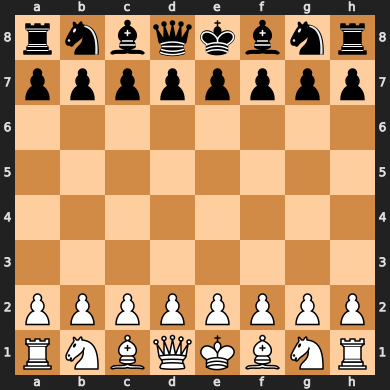

In [22]:
chess.Board()

It is clear that we will not be able to predict who wins a game using only PGN format as a feature. The format is simply too esoteric; when one player captures another player's piece, we don't even know what piece was captured unless we try to trace back who was last in that position! We have to help out our forecasting model, by extracting key features from the game and providing those as features. 

Towards that end, I engineer a number of features that will be valuable to identifying which side has a winning advantage. For a single, pre-determined time in the game, I will make these features:
* *How many of each piece* does each player have
* How much *mobility* does each player have, where mobility is defined as the total number of legal moves a player can make 
* Number of *blocked pawns*: pawns that cannot move forward because an enemy piece is directly in front of it. 
* Number of *isolated pawns*: pawns that have no friendly pawns in neighboring files. 
* Number of *doubled pawns*: pawns that have at least one other friendly pawn in the same rank. 

Having more pieces and higher mobility are both positives that will improve a player's chance of winning. Having blocked, isolated, or doubled pawns is considered a weakness that harms a player's chance of winning. At least some of these features should help us predict who will win the game.

To engineer all these features, I need to define a number of functions, all in the hidden code blocks below. 

In [171]:
# List of chess pieces and corresponding shortenings ('r' for black rook, 'R' for white rook, etc.)
pieces = ["Rook", "Knight", "Bishop", "Pawn", "Queen", "King"]
black = {"Rook": "r", "Knight": "n", "Bishop": "b", "Pawn": "p", "Queen": "q", "King": "k"}
white = {"Rook": "R", "Knight": "N", "Bishop": "B", "Pawn": "P", "Queen": "Q", "King": "K"}

In [172]:
# FUNCTIONS FOR REFORMATTING CHESS GAME NOTATION 

# Convert PGN format to FEN format, where the FEN notation records the position at a specific point in the game
def convert_PGN_to_FEN(pgn: str, nMoves: int) -> str:
    moves = [(x[1] if len(x) == 2 else x[0]) for x in [x.split('.') for x in pgn.split()]]
    # If not enough moves in the game
    if len(moves) - 1 < num_moves: # -1 removes game result (1-0 or equivalent)
        return np.nan
    # Make all moves, return final board position 
    board = chess.Board()
    for i in range(nMoves):
        board.push_san(moves[i])
    return board.fen()

# Formatting: return simplified FEN that contains only positional information
def simplify_FEN(FEN: str) -> str:
    return FEN.split(' ')[0] 

# Formatting: converting FEN to a matrix (list of lists) with shape 8 by 8
def convert_FEN_to_Matrix(FEN: str) -> list: 
    FEN = simplify_FEN(FEN)
    FEN = [line for line in FEN.split('/')]
    board = []
    for line in FEN:
        t = [list(char.replace(char, "0" * int(char)) if char.isdigit() else char) for char in line]
        board.append([item for sublist in t for item in sublist])
    return board 

In [ ]:
# Outputs score of a player, using 95331
def get_traditional_score(simple_FEN: str, player: str) -> int:
    scoring = [5,3,3,1,9] # rook, knight, bishop, pawn, queen
    piecesCount = count_pieces(simple_FEN, player)
    return sum([count * score for count, score in zip(piecesCount, scoring)])

In [323]:
# FUNCTIONS FOR FEATURE ENGINEERING:
#    Count of each piece
#    Traditional score of each side (based on 95331 heuristic) 
#    Difference in mobilities of players, where mobility is defined as the total number of legal moves
#    Number of 'bad' pawns

# Outputs counts of each piece in ["Rook", "Knight", "Bishop", "Pawn", "Queen"], for a specific player 
def count_pieces(simple_FEN: str, player: str) -> list:
    lst = []
    if player == "white": 
        for piece in white:
            if piece == "King": continue
            lst.append(simple_FEN.count(white[piece]))
    else:
        for piece in black:
            if piece == "King": continue
            lst.append(simple_FEN.count(black[piece]))
    return lst

# Outputs differences (white - black) in counts of each piece, in order ["Rook", "Knight", "Bishop", "Pawn", "Queen"]
def get_pieces_diff(simple_FEN: str) -> list:
    return [x - y for x,y in zip(count_pieces(simple_FEN, "white"), count_pieces(simple_FEN, "black"))]

# Outputs difference (white - black) in mobility between players.
def get_mobility_diff(PGN: str, nMoves: int, FEN: str) -> int:
    
    board = chess.Board(FEN)
    moves = list(filter(None, [(x.split('.')[1] if ('.' in x) else x.split('.')[0]) for x in PGN.split()]))
    
    # Mobility after nMoves
    if nMoves % 2 == 0:
        white_mobility = len(list(board.legal_moves))
    else:    
        black_mobility = len(list(board.legal_moves))
    
    # Mobility after nMoves + 1
    board.push_san(moves[nMoves])
    if nMoves % 2 == 0: 
        black_mobility = len(list(board.legal_moves))
    else: 
        white_mobility = len(list(board.legal_moves))
    return (white_mobility - black_mobility)

# Count bad pawns for a given player. Output is a list of the counts, in the order Blocked, Isolated, Doubled
def count_bad_pawns(matrix: list, player: str) -> list:
    pawn = {"white": "P", "black": "p"}
    blocked = isolated = doubled = 0
    # Look at each square of the board
    for row in range(8):
        for col in range(8):
            # Check for pawn at the square row, col
            if matrix[row][col] == pawn[player]:
                # Is blocked? 
                if player == "black" and matrix[row + 1][col].isupper():
                    blocked += 1
                elif player == "white" and matrix[row - 1][col].islower():
                    blocked += 1
                # Is isolated?
                if ((col - 1 < 0) or (pawn[player] not in [matrix[row][col - 1] for row in range(8)])) \
                and ((col + 1 > 7) or (pawn[player] not in [matrix[row][col + 1] for row in range(8)])):
                    isolated += 1
                # Is doubled?
                for rowp in range(8):
                    if rowp == row: continue
                    if pawn[player] in matrix[rowp][col]: 
                        doubled += 1
                        break
    return [blocked, isolated, doubled]

def get_bad_pawns_diff(matrix: list) -> list:
    return [x - y for x, y in zip(count_bad_pawns(matrix, "white"), count_bad_pawns(matrix, "black"))]

I also need to decide at what point in each game I want to make a prediction on who will win. Naively, I could choose to make my prediction after a certain, fixed number of turns for each game. However, this does not actually make sense in practice, because the pace of chess games can vary dramatically, so that after the same number of total moves, one game could still be in early midgame while another is already in endgame. I don't want to ask too much of my classification model, because doing so will reduce its performance, and that includes not asking it to try to distinguish different stages and distinguish different predictive properties of different stages. 

I define two points in a chess game at which I want to make predictions. I use the traditional scoring system for pieces in chess, 9 points for queens, 5 points for rooks, 3 points for bishops and knights, and 1 point for pawns. I then define these two times in 'midgame' and 'endgame' as follows:
* Midgame: The moment at which both White and Black have total scores that drop to or below 25. 
* Endgame: The moment at which both White and Black have total scores that drop to or below 13. 

The threshold of 13 to define the beginning of endgame agrees reasonably well with most definitions of endgame; for example, 13 was chosen as the threshold by Speelman in his Endgame Preparation book in 1981. The threshold of 25 is fairly arbitrary, but certainly defines a point where enough pieces have been captured to escape the 'opening' stage. 

The function defined below outputs the board (in 'FEN' format) at the chosen game stage. 

In [324]:
# Get the FEN of the board when both players' 95331 scores first fall below a certain threshold value. 
#     Output in the form: half-move-value at which threshold is crossed, FEN at that half-move
#     ex. threshold = 13 for beginning of endgame (Speelman)
def get_stage_FEN(PGN: str, threshold: int) -> tuple:
    
    # From pgn, get a list of all moves 
    moves = list(filter(None, [(x.split('.')[1] if ('.' in x) else x.split('.')[0]) for x in PGN.split()])) # removes emptry strings
    nHalfMoves = len(moves) - 1
    
    # Get scores at end of game 
    board = chess.Board()
    for i in range(nHalfMoves): board.push_san(moves[i])
    fen = board.fen()
    whiteScore, blackScore = get_traditional_score(fen, 1), get_traditional_score(fen, 2)

    # Return null
    if whiteScore > threshold or blackScore > threshold: return np.nan, np.nan

    # Binary search: Pop moves to go to an earlier stage of the game. Push moves to go to a later stage of the game.
    left = 0
    right = currMove = nHalfMoves 
    while left < right:
        # Update board
        steps = math.ceil((right - left) / 2)
        # Push moves to decrease scores to threshold 
        if whiteScore > threshold or blackScore > threshold: 
            for _ in range(steps):
                board.push_san(moves[currMove])
                currMove += 1
        # Pop moves to increase scores to threshold
        else: 
            for _ in range(steps):
                board.pop()
                currMove -= 1

        # Update scores 
        fen = board.fen()
        whiteScore, blackScore = get_traditional_score(fen, 1), get_traditional_score(fen, 2)

        # Update "left" and "right" 
        if whiteScore <= threshold and blackScore <= threshold:
            if right == currMove:
                break
            right = currMove
        else:
            left = (currMove if currMove != left else currMove + 1)
    
    # It is not always sensible to try to predict the game result if we're already at the end of the game. Return null.
    if currMove == nHalfMoves:
        return np.nan, np.nan
    
    return currMove, board.fen()

Using my functions above, I now engineer all the features I'll need for my two chosen points in each game.

In [350]:
# dfs stores the 4 dataframes in the order: amateur midgame, amateur endgame, expert midgame, expert endgame 
dfs = []
for data in [unfeatured_fics, unfeatured_pgnmentor]:
    for threshold in [25,13]:
        df = pd.DataFrame(index = data.index, columns = ["Turn", "FEN", "PGN", "Result"])
        df["PGN"], df["Result"] = data["PGN"], data["Result"]
        for index in data.index:
            df.loc[index, ["Turn", "FEN"]] = get_stage_FEN(data.loc[index, "PGN"], threshold)
        df.dropna(inplace = True)
        dfs.append(df)

In [353]:
featured_dfs = []
for data in dfs:
    # Initialize dataframe to carry new features
    index = data.index
    pieces_columns, bad_pawns_columns = [piece + "Diff" for piece in pieces[:5]], ["BlockedPawnDiff", "IsolatedPawnDiff", "DoublePawnDiff"]
    features_data = pd.DataFrame(index = index, columns = pieces_columns + bad_pawns_columns + ["MobilityDiff"])
    
    for index in data.index:
        # Some preprocessing of data in one row
        nMoves, FEN, PGN = data.loc[index, "Turn"], data.loc[index, "FEN"], data.loc[index, "PGN"]
        simple_FEN = simplify_FEN(FEN)
        matrix = convert_FEN_to_Matrix(FEN)
        
        # Feature engineering for differences in pieces 
        diffs = get_pieces_diff(simple_FEN)
        for i, piece in enumerate(pieces[:5]):
            features_data[piece + "Diff"][index] = diffs[i]       
            
        # Feature engineering for bad pawns
        features_data.loc[index, bad_pawns_columns] = get_bad_pawns_diff(matrix)
        
        # Feature engineering for mobility
        features_data.loc[index, "MobilityDiff"] = get_mobility_diff(PGN, nMoves, FEN)
        
    featured_dfs.append(pd.concat([data, features_data], axis = 1))
AmateurMidData, AmateurEndData, ExpertMidData, ExpertEndData = featured_dfs

I save my data with all added features, for easy re-loading. An example of what the dataframes now look like is shown below. 

In [361]:
# # Save results to file 
# AmateurMidData.to_csv("AmateurMid.csv")
# AmateurEndData.to_csv("AmateurEnd.csv")
# ExpertMidData.to_csv("ExpertMid.csv")
# ExpertEndData.to_csv("ExpertEnd.csv")

In [28]:
AmateurMidgameData = pd.read_csv("AmateurMid.csv", index_col = 0)
AmateurEndgameData = pd.read_csv("AmateurEnd.csv", index_col = 0)
ExpertMidgameData = pd.read_csv("ExpertMid.csv", index_col = 0)
ExpertEndgameData = pd.read_csv("ExpertEnd.csv", index_col = 0)

In [29]:
AmateurMidgameData.head()

,Turn,FEN,PGN,Result,RookDiff,KnightDiff,BishopDiff,PawnDiff,QueenDiff,BlockedPawnDiff,IsolatedPawnDiff,DoublePawnDiff,MobilityDiff
3,29,r1b2r1k/1ppN2pp/p1n5/8/2B5/P1PPp3/2P3PP/R2Q1RK...,1. e4 e5 2. Nc3 Bb4 3. Bc4 Bxc3 4. bxc3 Nf6 ...,0,0,0,0,0,1,0,0,2,-27
4,28,r3r1k1/ppp2ppp/8/4bb2/4n3/2P1B3/PP3PPP/RN1R2K1...,1. d4 d5 2. Bf4 e6 3. Nf3 Bd6 4. Bg5 Nf6 5. ...,1,0,0,-1,0,0,0,0,0,-9
5,72,6k1/2p4p/2p1r1p1/p2p1N1P/bq6/6Q1/5PP1/5RK1 w -...,1. e4 e5 2. Nf3 Nc6 3. Bb5 d6 4. Bxc6+ bxc6 ...,0,0,1,-1,-3,0,0,-1,-2,-8
8,57,r4rk1/p6p/1p3bp1/8/4b1P1/P1PQp3/1PK2P2/1RB3n1 ...,1. d4 e6 2. Nf3 Nf6 3. c3 d5 4. e3 b6 5. Qc2...,1,-1,-1,-1,0,1,0,-1,0,-37
10,44,r5r1/3k1pb1/b2ppnpp/p7/4P3/1P2NN2/PB1P1PPP/R1R...,1. e4 e6 2. Nc3 c6 3. Nf3 h6 4. Be2 Qc7 5. O...,0,0,1,-1,1,0,0,-1,0,12


#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Chess Piece Valuation and Game Result Prediction</p>

There are two main goals of this section. One is to use a simple, *linear*, classification model like Logistic Regression or Support Vector Classifier to predict who will win the chess game. 

The second is to, from the fitted classification model, extract the coefficients that multiply each feature and are used to make the predictions. These coefficients, well-defined only in linear models, tell us the predictive value of each feature. For example, we'll get a number telling us how valuable White having an extra rook is towards White winning, versus any other piece. We can then compare the numbers, essentially chess piece values, with the more traditional scoring of 9, 5, 3, 3, 1 for queens, rooks, etc. 

In the code block below, I train my classification model and make my predictions. I use each data set we have, for Amateur Midgame, Amateur Endgame, Expert Midgame, and Expert Endgame. I also train on two different sets of features: one includes *only* the differences in the number of pieces each player has, and the other also contains the bad-pawn (blocked, isolated, doubled pawns) and mobility features. 

I use Cohen's kappa score as an evaluation metric for my predictions. Cohen's kappa is a nice evaluation metric in our situation for a number of reasons. It is defined so that it describes the fraction of results predicted correctly, *excluding* those that were just predicted correctly by chance (i.e. a lucky guess). Cohen's kappa therefore avoid the biggest problem with 'accuracy', which is overinflated in an imbalanced classification problem by repeatedly guessing the more common class. Cohen's kappa is also more intuitive than an AUC-ROC score. 

I redo training and predictions multiple times to get 95% confidence intervals for my evaluation metric. 

In [108]:
n_repeats = 10

# Storage for logistic regression fitting parameters, and for evaluation metrics
coefficients = [[] for _ in range(8)]
kappas = [[] for _ in range(8)]
baseline_kappas = [[] for _ in range(8)]


# Feature groupings
pieces = ["Rook", "Knight", "Bishop", "Pawn", "Queen", "King"]
pieces_cols = [piece + "Diff" for piece in pieces[:5]]
bad_pawns_cols = ["BlockedPawnDiff", "IsolatedPawnDiff", "DoublePawnDiff"]
mobility_cols = ["MobilityDiff"]

ctr = 0

# Fit 4 sets of data, with 2 different feature spaces each
for feature_space in [pieces_cols, pieces_cols + bad_pawns_cols + mobility_cols]:
    for data in [AmateurMidgameData, AmateurEndgameData, ExpertMidgameData, ExpertEndgameData]:
        print('Beginning run {} of 8'.format(ctr + 1))

        # Get X and y, training and test
        X = data[feature_space]
        y = data["Result"]
        
        for _ in range(n_repeats):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)

            # Fit model and Make predictions 
            model = LogisticRegression(fit_intercept = False, class_weight = "balanced")
                # tried liblinear, newton-cg, lbfgs  -  no difference
                # tried adjusting C - no improvement 
                # fit_intercept = False - improves results 
                # class_weight = "balanced" - improves results 
            # model = SVC(kernel = "linear")
                # SVC - no improvement over logistic regression
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Save fitting parameters and evaluation metrics 
            coefficients[ctr].append(model.coef_[0])
            kappas[ctr].append(cohen_kappa_score(y_pred, y_test))
            
            # Make a new logistic model using standardized scores, and evaluate results 
            model = LogisticRegression()
            model.coef_ = (- np.array([[5, 3, 3, 1, 9]]) if ctr < 4 else - np.array([[5,3,3,1,9,-0.5,-0.5,-0.5,0.1]]))
            model.intercept_ = 0.
            model.classes_= np.array([0, 1])
            y_pred = model.predict(X_test.values)
            baseline_kappas[ctr].append(cohen_kappa_score(y_pred, y_test))

        ctr += 1

Beginning run 1 of 8
Beginning run 2 of 8
Beginning run 3 of 8
Beginning run 4 of 8
Beginning run 5 of 8
Beginning run 6 of 8
Beginning run 7 of 8
Beginning run 8 of 8


In [109]:
# Getting means and/or confidence intervals for (1) coefficients of linear model and (2) evaluation metric 

# Coefficients of model
mean_coefs = [sum(coefficients[index]) / n_repeats for index in range(8)]

# Evaluation metric
mean_kappas = [sum(kappas[index]) / n_repeats for index in range(8)]
mean_baseline_kappas = [sum(baseline_kappas[index]) / n_repeats for index in range(8)]

# Formatted (for presentation) confidence intervals for the evaluation metric 
kappas_with_confidence = ["{:.2f} \u00B1 {:.2f}".format(x,y) for x, y 
                              in zip(mean_kappas, [1.96 * stdev(x) / n_repeats ** 0.5 for x in kappas])]
baseline_kappas_with_confidence = ["{:.2f} \u00B1 {:.2f}".format(x,y) for x, y in
                                   zip(mean_baseline_kappas, [1.96 * stdev(x) / n_repeats ** 0.5  for x in baseline_kappas])]

In [110]:
labels = ["Amateur Midgame", "Amateur Endgame", "Expert Midgame", "Expert Endgame"]

PiecesOnlyResult = pd.concat([
    pd.DataFrame(kappas_with_confidence[:4], columns = ["Kappa"]), 
    pd.DataFrame(baseline_kappas_with_confidence[:4], columns = ["Kappa (95331)"]), 
    pd.DataFrame([mean_coefs[i] * 5 / mean_coefs[i][0] for i in range(4)], columns = pieces_cols)
          ], axis = 1)
PiecesOnlyResult.index = labels

def highlight_greater(row):
    kappa = row["Kappa"].split("\u00B1")[0]
    kappa95331 = row[("Kappa (95331)") if "Kappa (95331)" in row else "Kappa (Shannon 1949)"].split('\u00B1')[0] 
    if row["Kappa"] == "": 
        color = "lightgray"
    elif float(kappa) < float(kappa95331) - 0.02:
        color = "lightcoral"
    elif float(kappa) > float(kappa95331) + 0.02:
        color = "lightgreen"
    else:
        color = "white"
    background = ['background-color: {}'.format(color) for _ in row]
    return background

Score95331 = pd.DataFrame([["", "", 5, 3, 3, 1, 9]], 
             index = ["95331 values "], 
             columns = PiecesOnlyResult.columns)

pd.concat([PiecesOnlyResult, Score95331], axis = 0).style.apply(highlight_greater, axis=1)

,Kappa,Kappa (95331),RookDiff,KnightDiff,BishopDiff,PawnDiff,QueenDiff
Amateur Midgame,0.36 ± 0.02,0.35 ± 0.02,5.000000,3.848639,4.054197,1.523413,7.507990
Amateur Endgame,0.51 ± 0.02,0.51 ± 0.02,5.000000,3.185326,3.676569,1.232455,7.222444
Expert Midgame,0.19 ± 0.01,0.18 ± 0.01,5.000000,2.185907,4.302808,4.619162,3.943260
Expert Endgame,0.37 ± 0.00,0.44 ± 0.01,5.000000,2.720785,3.336074,3.124520,4.193291
95331 values,,,5.000000,3.000000,3.000000,1.000000,9.000000


In [111]:
AllFeaturesResult = pd.concat([
    pd.DataFrame(kappas_with_confidence[4:8], columns = ["Kappa"]), 
    pd.DataFrame(baseline_kappas_with_confidence[4:8], columns = ["Kappa (Shannon 1949)"]), 
    pd.DataFrame([mean_coefs[i] * 5 / mean_coefs[i][0] for i in range(4,8)], columns = pieces_cols + bad_pawns_cols + ["MobilityDiff"])
          ], axis = 1)
AllFeaturesResult.index = labels

Shannon1949 = pd.DataFrame([["", "", 5, 3, 3, 1, 9, -0.5, -0.5, -0.5, 0.1]], 
             index = ["Shannon 1949"], 
             columns = AllFeaturesResult.columns)

pd.concat([AllFeaturesResult, Shannon1949], axis = 0).style.apply(highlight_greater, axis=1)

,Kappa,Kappa (Shannon 1949),RookDiff,KnightDiff,BishopDiff,PawnDiff,QueenDiff,BlockedPawnDiff,IsolatedPawnDiff,DoublePawnDiff,MobilityDiff
Amateur Midgame,0.36 ± 0.01,0.36 ± 0.01,5.000000,3.843010,4.135910,1.512344,7.224041,-0.426983,-0.291868,-0.128834,0.114810
Amateur Endgame,0.51 ± 0.03,0.51 ± 0.03,5.000000,3.215652,3.784472,1.416467,6.829518,-0.378407,-0.217435,-0.105707,0.114424
Expert Midgame,0.27 ± 0.01,0.23 ± 0.01,5.000000,2.088699,4.524157,4.908509,3.279411,-1.678651,-0.844513,-0.099627,0.279509
Expert Endgame,0.46 ± 0.01,0.41 ± 0.01,5.000000,2.704622,3.281451,3.607261,3.624072,-0.729117,-0.278615,-0.490474,0.221070
Shannon 1949,,,5.000000,3.000000,3.000000,1.000000,9.000000,-0.500000,-0.500000,-0.500000,0.100000


In each table, 'Kappa' is the evaluation metric result, having fitted Logistic Regression on the features listed in the columns. 'Kappa (95331)' in the first table is the Kappa score produced from setting the Logistic Regression coefficients equal to the traditional piece scores (listed in the row '95331 values'). 'Kappa (Shannon 1949)' in the second table is the Kappa score produced from the same procedure, but using the scores listed in the row 'Shannon 1949'. All values for kappa are expressed with their 95% confidence intervals.

In the first table, our logistic regression does no better than the 95331 values. In the red row, 'Expert Endgame', it even does worse! This is an unfortunate side effect of the fact that Logistic Regression is working on optimizing its loss function (binary cross entropy), and minimizing this loss function does not have the same effect as maximizing the kappa score, or any other typical evaluation metric. Support vector classifier, which uses a hinge loss function, also fails in this regard. No amount of hyperparameter tuning on my part seems to resolve this issue. 

In the second table, our logistic regression does significantly better than Shannon 1949 values, for the expert games only. Given this result, we can now try to make sense of the values given for each coefficient. These values are scaled so that 'RookDiff' is assigned to the value 5. The greatest anomalies that result are: the pawn is worth much more than 1, and the queen has extremely low point value compared to what we'd expect. The queen even has a smaller value than the rook, even though it is strictly more powerful. 

It is interesting to think that the coefficients needed to *predict* victory, in an actual game, are not necessarily the same thing as the coefficients than can be used to *guide action* for winning the game. It would be ridiculous for someone to see these values and decide to sacrifice a queen for a rook. Similarly, if we were to plug my coefficients into the values for an evaluation function used to run a chess engine, the chess engine would lose every match. But our coefficients are telling us that, *given* a human, expert chess player has chosen to play in such a way that they have 0 queens and 1 rook, they are likely better off than if they had 1 queen and 0 rooks. In other words, an experienced chess player will never sacrifice a queen unless it gains them compensating benefits in other ways. In the specific context of two expert players in a tournament setting, I could use the coefficients of my model -which treat a rook as more valuable than a queen- to make a better prediction for who wins, than if I were to use more intuitive, sensible values that treat a queen as more valuable than a rook. 

One last note of interest is that including the features for bad pawns and mobility causes the kappa values for expert games to increase drastically, even though the kappa scores for amateur games stay the same. It should be expected that amateur players cannot make as strong use of their positions to win a game, and so the number of pieces they have is the dominating predictor in who wins. It should also be expected that experts should be able to leverage any advantage in position to win despite fewer pieces. We can see that the trend in our evaluation metric scores reflects these expectations. 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Feature Engineering (Part 2) </p>


In the last section, I used a restricted number of features and used logistic regression so that I could easily interpret the resulting fitted coefficients. However, I can create a much better performing model by not imposing these restrictions. In this section, I engineer several more features that can be used to predict victory. In the next section, I'll use XGBClassifier to do the predictions on the full dataset. 

The features I make in this section are:
* *Two Bishops*: whether or not each player has two bishops. 
* *Two Knights*: whether or not each player has two knights. 
* *Number of 'Advanced' Pawns*: how many pawns each player has, that have advanced to the opponent's side of the board
* *Number of 'Advanced' Pieces*: how many pieces each player has, excluding pawns, that have advanced to the opponent's side of the board
* *Center Control*: number of pieces each player has in the central four squares of the board. I ultimately remove this feature during modelling because it reduces performance. 

In [250]:
dfs = [AmateurMidgameData, AmateurEndgameData, ExpertMidgameData, ExpertEndgameData]

for df in dfs:
    # Two-Bishops or Two-Knights
    df["TwoBishops_White"] = df.FEN.apply(lambda s: 1 if (s.count('B') == 2) else 0)
    df["TwoBishops_Black"] = df.FEN.apply(lambda s: 1 if (s.count('b') == 2) else 0)
    df["TwoKnights_White"] = df.FEN.apply(lambda s: 1 if (s.count('N') == 2) else 0)
    df["TwoKnights_Black"] = df.FEN.apply(lambda s: 1 if (s.count('n') == 2) else 0)
    # Number of pawns moved past mid-point of board
    df["AdvancedPawns_White"] = df.FEN.apply(lambda s: ''.join(simplify_FEN(s).split('/')[:4]).count('P')) 
    df["AdvancedPawns_Black"] = df.FEN.apply(lambda s: ''.join(simplify_FEN(s).split('/')[4:]).count('p')) 
    # Number of pieces (*excluding* pawns) moved past mid-point of board
    df["AdvancedPieces_White"] = df.FEN.apply(lambda s: len([char for char in\
                                                             ''.join(simplify_FEN(s).split('/')[:4]).replace('P', '')\
                                                             if char.isupper()]))
    df["AdvancedPieces_Black"] = df.FEN.apply(lambda s: len([char for char in\
                                                         ''.join(simplify_FEN(s).split('/')[4:]).replace('p', '')\
                                                         if char.islower()]))
    # Center control, measured by how many pieces are in center 4 squares (or extended center of 16 squares) causes worse performance overall 
    # # Center control --- Number of pieces in center 4 squares
    # df["CenterControl_White"] = df.FEN.apply(lambda s: len([char for char in\
    #                                                     ''.join(list(np.array(convert_FEN_to_Matrix(s))[3:5, 3:5].flatten()))\
    #                                                     if char.isupper()]))
    # df["CenterControl_Black"] = df.FEN.apply(lambda s: len([char for char in\
    #                                                     ''.join(list(np.array(convert_FEN_to_Matrix(s))[3:5, 3:5].flatten()))\
    #                                                     if char.islower()]))

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Game Result Prediction Using XGBoost </p>

In this section, I use all my engineered features and XGBoost to make a better classification model for predicting victory. 

In [281]:
n_repeats = 10

# Storage for logistic regression fitting parameters, and for evaluation metrics
coefficients = [[] for _ in range(4)]
kappas = [[] for _ in range(4)]
baseline_kappas = [[] for _ in range(4)]

# Fit 4 sets of data, with 2 different feature spaces each
for ctr, data in enumerate(dfs):
    print('Beginning run {} of 4'.format(ctr + 1))

    # Get X and y, training and test
    X = data.drop(["Turn", "FEN", "PGN", "Result"], axis = 1)
    y = data["Result"]

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)

        # Fit model and Make predictions 
        evalset = [(X_train, y_train), (X_test, y_test)]
        model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
            # n_estimators = 100 (default) is good. 
            # reg_lambda: tuning up is bad. tuning down has very minimal change. 
        
        model.fit(X_train, y_train, eval_metric='auc', eval_set=evalset, verbose = 0)
        y_pred = model.predict(X_test)

        # Save fevaluation metric
        kappas[ctr].append(cohen_kappa_score(y_pred, y_test))
    
# Evaluation metric -- confidence intervals
mean_kappas = [sum(kappas[index]) / n_repeats for index in range(4)]
kappas_with_confidence = ["{:.2f} \u00B1 {:.3f}".format(x,y) for x, y 
                              in zip(mean_kappas, [1.96 * stdev(x) / n_repeats ** 0.5 for x in kappas])]

Beginning run 1 of 4
Beginning run 2 of 4
Beginning run 3 of 4
Beginning run 4 of 4


I used plots of training and testing validation scores, in the hidden code block below, to guide whether I tuned any hyperparameters in XGBoost. 

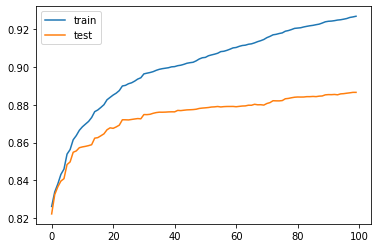

In [279]:
results = model.evals_result()
plt.plot(results['validation_0']['auc'], label='train')
plt.plot(results['validation_1']['auc'], label='test')
plt.legend()
plt.show()

In [284]:
labels = ["Amateur Midgame", "Amateur Endgame", "Expert Midgame", "Expert Endgame"]
for i, kappa in enumerate(kappas_with_confidence):
    print('For {}, kappa score is {}'.format(labels[i], kappa))

For Amateur Midgame, kappa score is 0.33 ± 0.025
For Amateur Endgame, kappa score is 0.51 ± 0.026
For Expert Midgame, kappa score is 0.35 ± 0.003
For Expert Endgame, kappa score is 0.61 ± 0.007


For the expert midgame and expert endgame, these are much better performances than we were seeing earlier. Using XGBClassifier and adding many more features each improved the kappa scores by several percent. 

For amateur games, the performance is no better than before, when we used logistic regression and very few features. As discussed earlier, the result of amateur games seems to depend only on which player has more pieces. Because the only predictive feature is the number of pieces each player has, adding position-related features tends to distract and clutter training with irrelevant information, which reduces kappa values. 